### Predicting Winner in League of Legends Ranked Matches

Datasets:

Ranked Games: https://www.kaggle.com/datasnaek/league-of-legends

High ELO Ranked Games: https://www.kaggle.com/gyejr95/league-of-legends-challenger-ranked-games2020


This project uses a dataset of ranked matches from League of Legends to predict the winner in ranked matches. LoL is a multiplayer online battle arena game where two teams of 5 compete against each other to destroy the other team's Nexus (a structure located in each team's base). Ranked matches are games where teams compete to climb the leaderboard and ranking tiers within the game (ranges from Iron to Challenger, 9 total tiers).

This project will train a dataset of ranked matches and a dataset of only high elo ranked matches (Master, Grand Master, and Challenger)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

### Predicting Winner in Ranked Matches

In [2]:
matches = pd.read_csv("games.csv")
matches = matches.drop(columns=["gameId", "creationTime", "seasonId"])
matches

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1id,t1_champ1_sum1,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,1949,1,2,1,1,1,1,2,8,12,...,5,0,0,1,1,114,67,43,16,51
1,1851,1,1,1,1,0,1,1,119,7,...,2,0,0,0,0,11,67,238,51,420
2,1493,1,2,1,1,1,2,0,18,4,...,2,0,0,1,0,157,238,121,57,28
3,1758,1,1,1,1,1,1,0,57,4,...,0,0,0,0,0,164,18,141,40,51
4,2094,1,2,1,1,1,1,0,19,4,...,3,0,0,1,0,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,1944,2,1,2,2,0,2,0,19,12,...,10,2,0,4,0,55,-1,90,238,157
51486,3304,2,1,1,2,2,2,2,90,4,...,11,7,4,4,1,157,55,119,154,105
51487,2156,2,2,2,2,0,1,0,141,11,...,10,2,0,2,0,113,122,53,11,157
51488,1475,2,2,2,2,0,2,0,121,11,...,11,3,0,1,0,154,39,51,90,114


<AxesSubplot:>

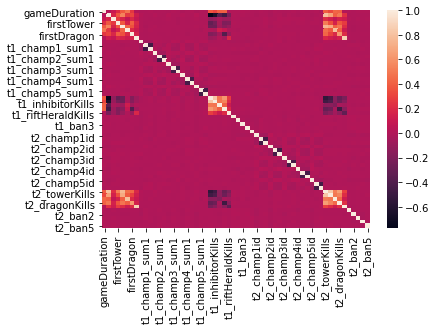

In [3]:
sns.heatmap(matches.corr())

The correlation heatmap is very busy since there are a lot of variables. This is because variables like champ and ban is unique to each individual player (5v5, 10 players total). To reduce the number of features, we can run a principal component analysis before we train a model.

In [4]:
from sklearn.preprocessing import StandardScaler

#separating features
features = matches.drop(columns=["winner"])
X = features.values
#separating target
y = matches[["winner"]].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
pca_df = pd.DataFrame(data=principalComponents, columns = ["pca1", "pca2"])

In [6]:
matches_df = pd.concat([pca_df, matches[['winner']]], axis = 1)
matches_df

,pca1,pca2,winner
0,-1.386240,1.686671,1
1,-3.230689,0.687141,1
2,-1.334975,-0.183462,1
3,-2.829340,0.615519,1
4,-2.086105,1.355091,1
...,...,...,...
51485,2.370398,-1.323635,2
51486,5.286490,4.507490,2
51487,1.675478,-1.226365,2
51488,2.233855,-2.128003,2


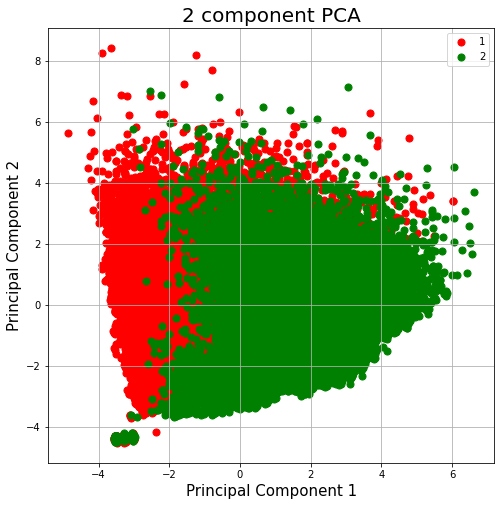

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

ax.set_title('2 component PCA', fontsize = 20)
targets = [1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = matches_df['winner'] == target
    ax.scatter(matches_df.loc[indicesToKeep, 'pca1'],
               matches_df.loc[indicesToKeep, 'pca2'],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

In [8]:
pca.explained_variance_ratio_

array([0.09486616, 0.05159764])

Running a PCA shows us that reducing the number of features may not be the best approach. The explained variance ration is a metric used to measure how much of the data k number of principal componenets can explain. In this case, the top 2 features with the "best" principal components only account for a tiny fraction of the data. This makes sense since there are, essentially, an infinite number of variables that can decide the outcome of a LoL match. With our limited data, it will be difficult to predict winners but we should move forward with keeping all features for our model.

### Comparing Models with PyCaret

### Decision Tree for Predicting Winner

In [ ]:
X

A decision tree tries to make a prediction (based on features) by making decisions through splitting a node into two or more sub-nodes. In this case, the decision tree will use all available features (i.e. gameDuration, firstBlood, etc.) to make a prediction on the target, winner. The algorithm will begin with an original set as the root node. This will be the entire dataset of features. After each iteration, the algorithm goes through unused features of this set and calculates entropy and information gain of the feature, then splits the feature with the smallest entropy or largest information gain to produce a subset. The algorithm reiterates this process on each subset and goes through features that were not selected until a decision is made.


Source: https://towardsdatascience.com/a-dive-into-decision-trees-a128923c9298

In [17]:
#the code below takes a fitted tree model and plots a visual representation of the algorithm's decisions
import graphviz
import matplotlib.pyplot as plt
import pydotplus
import matplotlib.image as mpimg
import io
from sklearn.tree import export_graphviz

def draw_tree(tree):
    dot_data = export_graphviz(tree,
                               out_file=None,
                               feature_names=features, 
                               class_names=["Up", "Down"],
                               filled=True,
                               rounded=True,
                               special_characters=True,
                               proportion = True)
    
    graph = graphviz.Source(dot_data)
    graph.format = "png"
    graph.render("tree",view=True)
    plt.figure(figsize=(50,30))
    img = mpimg.imread("tree.png")
    imgplot = plt.imshow(img)

    plt.show()

In [9]:
from sklearn.model_selection import train_test_split

#separating features
X = matches.drop(columns=["winner"])
#separating target
y = matches[["winner"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

### Determining Best Depth using AUC
One of the parameters of a decision tree is nax_depth, which defines the number of levels the tree will iterate through to arrive at a decision.

In [11]:
depths = np.arange(2,10) # define the depths
results = [] # create an empty data frame for our results

for depth in depths:
    best_depth_tree = DecisionTreeClassifier(max_depth = depth) # creating an instance of a decision tree
    results.append(cross_val_score(best_depth_tree, X, y, scoring="roc_auc", # getting the cv accuracy metric for the tree at each depth
                cv=3).mean())
    
test = pd.DataFrame({'depths':depths, 'mean_roc_auc':results})
test.sort_values("mean_roc_auc", ascending=False)

In [12]:
test = pd.DataFrame({'depths':depths, 'mean_roc_auc':results})
test.sort_values("mean_roc_auc", ascending=False)

,depths,mean_roc_auc
3,5,0.995345
4,6,0.995218
2,4,0.993607
5,7,0.993592
6,8,0.989739
1,3,0.988127
7,9,0.985079
0,2,0.973918


In [19]:
matches_win_tree = DecisionTreeClassifier(max_depth=5)
matches_win_tree.fit(X_train, y_train)
simple_predictions = matches_win_tree.predict(X_test)
print(metrics.confusion_matrix(y_test, simple_predictions))

[[8359  259]
 [ 343 8031]]


In [21]:
print(metrics.classification_report(y_test, simple_predictions))

              precision    recall  f1-score   support

           1       0.96      0.97      0.97      8618
           2       0.97      0.96      0.96      8374

    accuracy                           0.96     16992
   macro avg       0.96      0.96      0.96     16992
weighted avg       0.96      0.96      0.96     16992



In [23]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, simple_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, simple_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, simple_predictions)))

Mean Absolute Error: 0.03542843691148776
Mean Squared Error: 0.03542843691148776
Root Mean Squared Error: 0.18822443229158048


In [24]:
cross_val_score(tree, X, y,
                scoring="roc_auc", 
                cv=3).mean()

NameError: name 'tree' is not defined

In [ ]:
dict(zip(
    features,
    tree.feature_importances_
))

In [ ]:
draw_tree(simple_tree)